In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt

2024-05-18 18:10:43.975907: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def prepare_data(data, time_steps=60):
    X, y = [], []
    for i in range(len(data)-time_steps):
        X.append(data[i:i+time_steps])
        y.append(data[i+time_steps])
    return np.array(X), np.array(y)

In [3]:
def build_model(shape):
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=shape))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

In [4]:
def forecast_stock(stock):
    print(f"\nForecasting for {stock}...")
    
    stock_data = df[df['Symbol']==stock].set_index('Date')
    train_data = stock_data[:'2019-12-31'].copy()
    test_data = stock_data['2020-01-01':'2021-01-01'].copy()
    
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(train_data[['Close']])
    x_train, y_train = prepare_data(scaled_data)
    
    model = build_model((x_train.shape[1], 1))
    checkpoint = ModelCheckpoint(f"{stock}_model.h5", save_best_only=True)
    model.fit(x_train, y_train, epochs=5, batch_size=32, callbacks=[checkpoint])
    
    # Ensure the model is saved correctly
    model.save(f"{stock}_model.h5")
    
    # Load the model
    model = load_model(f"{stock}_model.h5")
    
    # Prepare the test data
    test_scaled = scaler.transform(test_data[['Close']])
    x_test, y_test = prepare_data(test_scaled)
    
    predictions = model.predict(x_test)
    predicted = scaler.inverse_transform(predictions)
    
    # Align the actual and predicted values
    actual = test_data['Close'].values[-len(predicted):]
    
    rmse = sqrt(mean_squared_error(actual, predicted))
    mse = mean_squared_error(actual, predicted)
    nrmse = rmse / (max(actual) - min(actual))
    mae = mean_absolute_error(actual, predicted)
    
    actual_growth = (actual[-1] - actual[0]) / actual[0]
    predicted_growth = (predicted[-1] - predicted[0]) / predicted[0]
    
    metrics = pd.DataFrame({
        'RMSE': rmse, 
        'MSE': mse,
        'Normalized RMSE': nrmse,
        'MAE': mae,
        'Actual Growth': actual_growth,
        'Predicted Growth': predicted_growth
    }, index = [stock])
    
    plt.figure(figsize=(10,6))
    plt.plot(test_data.index[-len(predicted):], actual, label='Actual')
    plt.plot(test_data.index[-len(predicted):], predicted, label='Predicted')
    plt.title(f"{stock} Closing Price")
    plt.xlabel("Date")
    plt.ylabel("Closing price in INR")
    plt.legend()
    plt.show()
    
    print(metrics)
    
    return metrics


Forecasting for TATAMOTORS...


2024-05-18 18:10:44.948962: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
2024-05-18 18:10:45.059425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-18 18:10:45.059963: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-18 18:10:45.0

Epoch 1/5


2024-05-18 18:10:45.233538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-18 18:10:45.234189: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-18 18:10:45.234873: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

37/37 [==============================] - 5s 57ms/step - loss: 0.0378
Epoch 2/5
37/37 [==============================] - 2s 59ms/step - loss: 0.0055
Epoch 3/5
37/37 [==============================] - 2s 61ms/step - loss: 0.0046
Epoch 4/5
37/37 [==============================] - 3s 68ms/step - loss: 0.0046
Epoch 5/5
37/37 [==============================] - 2s 64ms/step - loss: 0.0045


2024-05-18 18:10:59.595550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-18 18:10:59.596155: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-18 18:10:59.596893: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 28ms/step


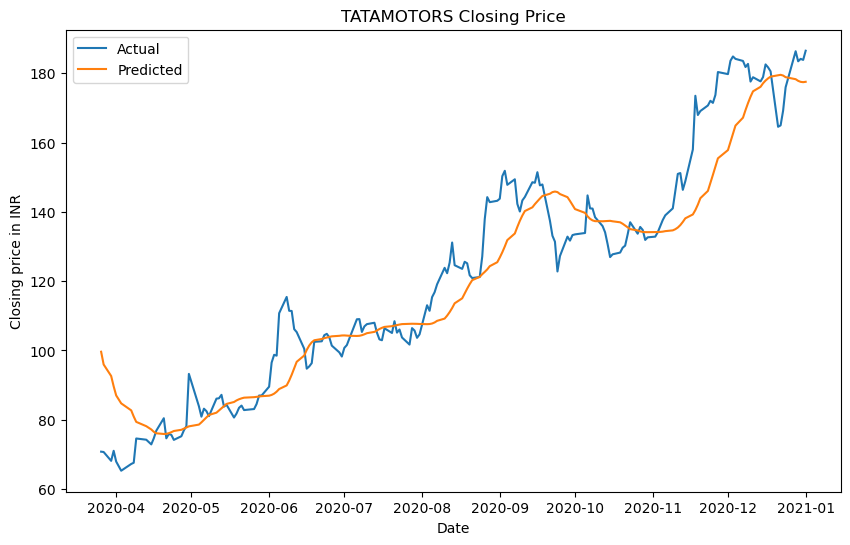

                 RMSE        MSE  Normalized RMSE       MAE  Actual Growth  \
TATAMOTORS  11.043628  121.96172         0.091119  8.087977       1.634181   

            Predicted Growth  
TATAMOTORS          0.781822  

Forecasting for EICHERMOT...
Epoch 1/5


2024-05-18 18:11:01.137207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-18 18:11:01.137748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-18 18:11:01.138319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

37/37 [==============================] - 5s 77ms/step - loss: 0.0464
Epoch 2/5
37/37 [==============================] - 2s 62ms/step - loss: 0.0077
Epoch 3/5
37/37 [==============================] - 2s 62ms/step - loss: 0.0071
Epoch 4/5
37/37 [==============================] - 2s 62ms/step - loss: 0.0066
Epoch 5/5
37/37 [==============================] - 2s 64ms/step - loss: 0.0065


2024-05-18 18:11:16.366439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-18 18:11:16.367391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-18 18:11:16.367960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 15ms/step


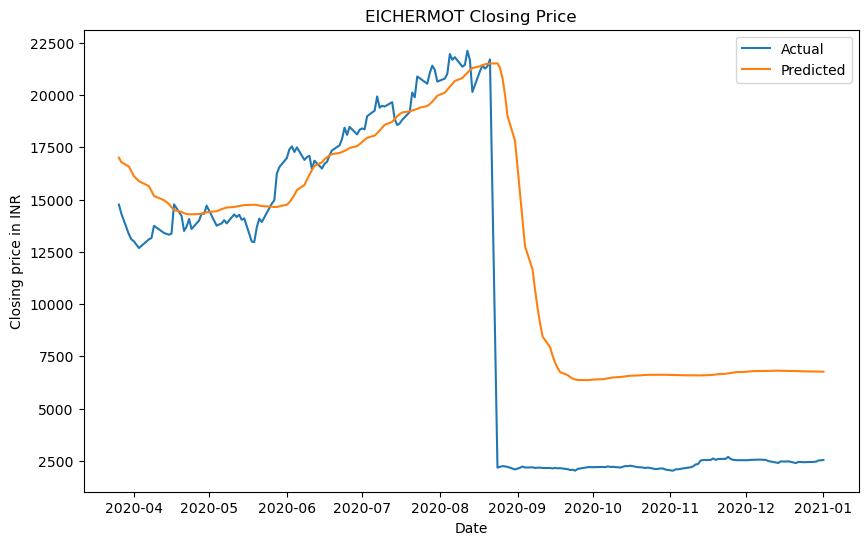

                  RMSE           MSE  Normalized RMSE          MAE  \
EICHERMOT  4820.485985  2.323709e+07          0.23998  3264.148334   

           Actual Growth  Predicted Growth  
EICHERMOT      -0.827706         -0.602014  

Forecasting for HEROMOTOCO...


2024-05-18 18:11:17.372007: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-18 18:11:17.372549: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-18 18:11:17.373394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2024-05-18 18:11:17.704144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-18 18:11:17.705177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-18 18:11:17.705936: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

37/37 [==============================] - 5s 67ms/step - loss: 0.0353
Epoch 2/5
37/37 [==============================] - 3s 81ms/step - loss: 0.0090
Epoch 3/5
37/37 [==============================] - 3s 74ms/step - loss: 0.0085
Epoch 4/5
37/37 [==============================] - 3s 80ms/step - loss: 0.0076
Epoch 5/5
37/37 [==============================] - 3s 75ms/step - loss: 0.0071


2024-05-18 18:11:34.504630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-18 18:11:34.505546: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-18 18:11:34.506235: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 19ms/step


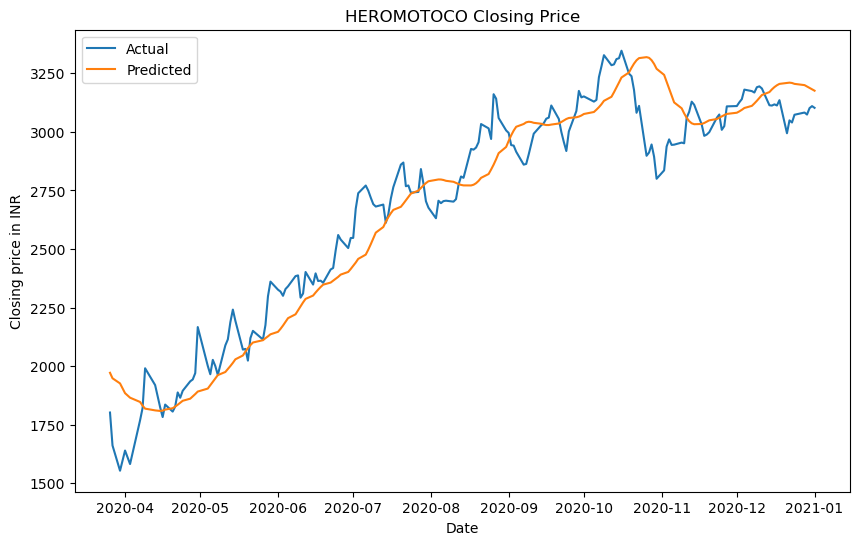

                  RMSE           MSE  Normalized RMSE         MAE  \
HEROMOTOCO  145.121004  21060.105817          0.08094  111.821501   

            Actual Growth  Predicted Growth  
HEROMOTOCO       0.721877          0.610835  

Forecasting for MARUTI...


2024-05-18 18:11:35.699571: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-18 18:11:35.700187: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-18 18:11:35.700889: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/5


2024-05-18 18:11:36.016818: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-18 18:11:36.017784: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-18 18:11:36.018630: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

37/37 [==============================] - 5s 71ms/step - loss: 0.0307
Epoch 2/5
37/37 [==============================] - 2s 64ms/step - loss: 0.0062
Epoch 3/5
37/37 [==============================] - 2s 65ms/step - loss: 0.0058
Epoch 4/5
37/37 [==============================] - 2s 65ms/step - loss: 0.0049
Epoch 5/5
37/37 [==============================] - 2s 66ms/step - loss: 0.0047


2024-05-18 18:11:50.788927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-18 18:11:50.789955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-18 18:11:50.790702: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 16ms/step


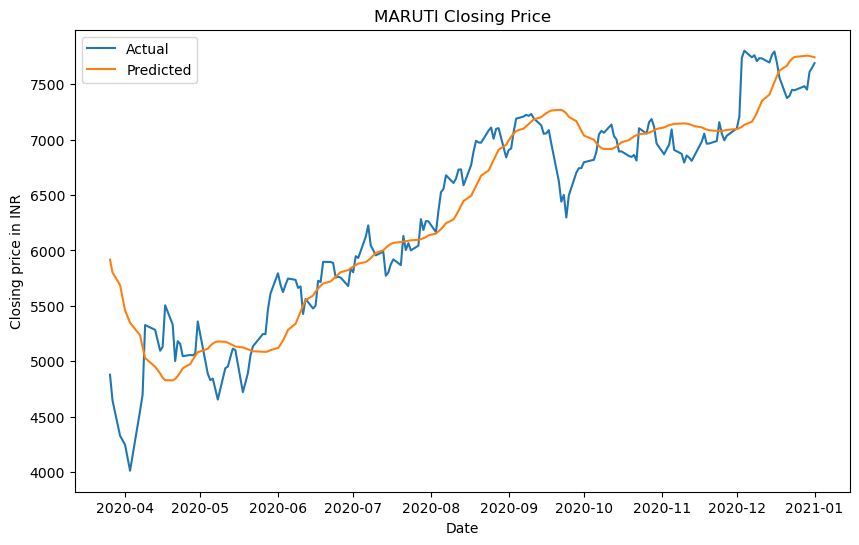

              RMSE            MSE  Normalized RMSE         MAE  Actual Growth  \
MARUTI  358.402728  128452.515504         0.094524  257.518899       0.576732   

        Predicted Growth  
MARUTI          0.308722  

Forecasting for M&M...
Epoch 1/5


2024-05-18 18:11:51.961284: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-18 18:11:51.961772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-18 18:11:51.962238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

37/37 [==============================] - 6s 83ms/step - loss: 0.0485
Epoch 2/5
37/37 [==============================] - 2s 66ms/step - loss: 0.0100
Epoch 3/5
37/37 [==============================] - 2s 65ms/step - loss: 0.0097
Epoch 4/5
37/37 [==============================] - 2s 60ms/step - loss: 0.0088
Epoch 5/5
37/37 [==============================] - 2s 63ms/step - loss: 0.0080


2024-05-18 18:12:07.554948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-18 18:12:07.555962: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-18 18:12:07.556729: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 13ms/step


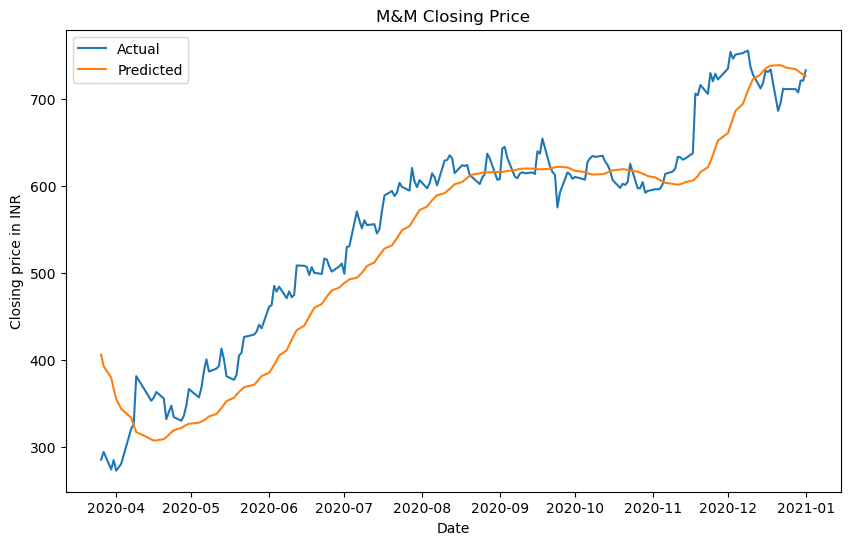

          RMSE          MSE  Normalized RMSE        MAE  Actual Growth  \
M&M  44.352472  1967.141768         0.091989  35.794144       1.565499   

     Predicted Growth  
M&M          0.787308  

Forecasting for BAJAJ-AUTO...
Epoch 1/5


2024-05-18 18:12:08.638764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-18 18:12:08.639351: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-18 18:12:08.639911: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

37/37 [==============================] - 5s 71ms/step - loss: 0.0486
Epoch 2/5
37/37 [==============================] - 3s 79ms/step - loss: 0.0093
Epoch 3/5
37/37 [==============================] - 3s 79ms/step - loss: 0.0083
Epoch 4/5
37/37 [==============================] - 2s 64ms/step - loss: 0.0084
Epoch 5/5
37/37 [==============================] - 2s 66ms/step - loss: 0.0075


2024-05-18 18:12:24.829278: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-05-18 18:12:24.830177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-05-18 18:12:24.830758: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

7/7 [==============================] - 1s 19ms/step


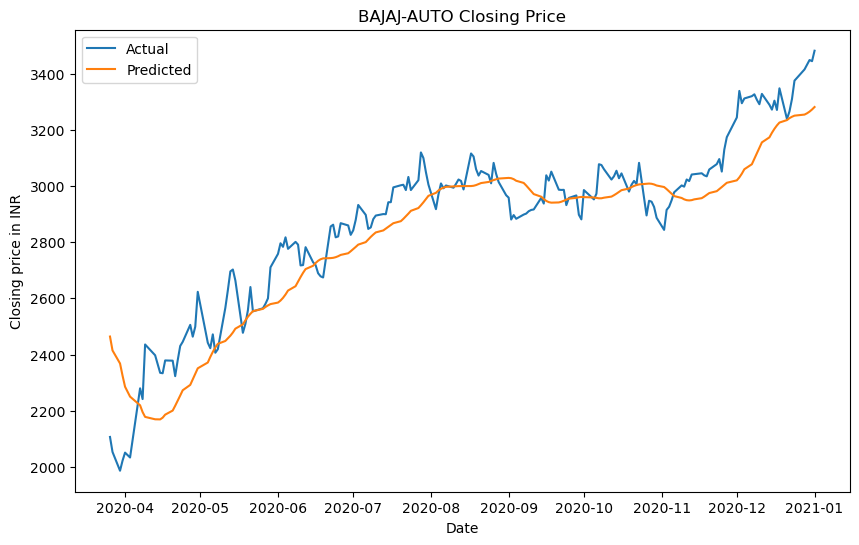

                  RMSE           MSE  Normalized RMSE        MAE  \
BAJAJ-AUTO  124.464152  15491.325217         0.083279  98.130873   

            Actual Growth  Predicted Growth  
BAJAJ-AUTO       0.652348          0.331462  
                   RMSE           MSE  Normalized RMSE          MAE  \
TATAMOTORS    11.043628  1.219617e+02         0.091119     8.087977   
EICHERMOT   4820.485985  2.323709e+07         0.239980  3264.148334   
HEROMOTOCO   145.121004  2.106011e+04         0.080940   111.821501   
MARUTI       358.402728  1.284525e+05         0.094524   257.518899   
M&M           44.352472  1.967142e+03         0.091989    35.794144   
BAJAJ-AUTO   124.464152  1.549133e+04         0.083279    98.130873   

            Actual Growth  Predicted Growth  
TATAMOTORS       1.634181          0.781822  
EICHERMOT       -0.827706         -0.602014  
HEROMOTOCO       0.721877          0.610835  
MARUTI           0.576732          0.308722  
M&M              1.565499          0.787308

In [5]:
# Load the data
df = pd.read_csv('~/Downloads/MPS DS Course Materials/DATA 606/sectoralstockanalysis/Dataset/Merged Data/Modified/Automobile_mod.csv', parse_dates=['Date'])

stocks = df['Symbol'].unique()
metrics_list = []

for stock in stocks:
    metrics = forecast_stock(stock)
    metrics_list.append(metrics)

metrics_df = pd.concat(metrics_list)
print(metrics_df)